In [48]:
# 텍스트 분류용 Transformer 모델 - News Analysis, 뉴스 카테고리 분류
# AG News 데이터셋 : 뉴스 카테고리 분류(정치, 경제, 과학/기술, 스포츠)
# 다국어 모델 적용

In [75]:
# 1. 라이브러리 불러오기
from datasets import load_dataset # HuggingFace Datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments # HuggingFace

In [76]:
# 2. 데이터셋 불러오기

# HuggingFace AG News Datasets
# 뉴스 기사 제목과 본문 일부가 포함된 텍스트 데이터
# 4개 카테고리(label):World,Sports,Business,Sci/Tech
# 학습용 약 120,000건, 테스트용 약 7,600건, 데이터셋 구조 {'train':Dataset, 'test':Dataset} 형태로 반환
dataset = load_dataset('ag_news') # 

# 빠른 테스트용: 데이터 크기 줄이기(학습용 3000개, 테스트용 600개만 사용)
small_train = dataset['train'].shuffle(seed=42).select(range(10000))
small_test = dataset['test'].shuffle(seed=42).select(range(2000))

# 최종 학습용: 전체 12만 건 사용
full_train = dataset['train']
full_test = dataset['test']

print(small_train[0])
print(small_train.shape, small_test.shape)

{'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.', 'label': 0}
(10000, 2) (2000, 2)


In [77]:
# 3. 토크나이저 준비
model_name = "xlm-roberta-base" # 다국어 모델
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 중요: 문서 단위 분류용 토크나이징 (동적 패딩, 문서 길이만 유지)
def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True, # 문서가 256 토큰을 넘으면 잘라냄
        max_length=256,    # 길이 제한만, padding은 collator가 배치마다 처리
    )

train_enc = small_train.map(tokenize, batched=True, remove_columns=["text"])
test_enc  = small_test.map(tokenize,  batched=True, remove_columns=["text"])

# 4) 라벨 정렬: 반드시 long, 1차원
# datasets는 원래 'label' 컬럼을 유지하므로 set_format에서 labels로 바꾸지 않아도 됨
train_enc = train_enc.rename_column("label", "labels")
test_enc  = test_enc.rename_column("label", "labels")

train_enc.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_enc.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map: 100%|██████████| 2000/2000 [00:00<00:00, 16023.29 examples/s]


In [78]:
# 4. 모델 준비
num_labels = 4 # AG News는 4개 카테고리 (0:정치, 1:경제, 2:과학/기술, 3:스포츠)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=num_labels
)
model.config.problem_type = "single_label_classification"  # 분류 문제로 고정, 각 입력 문서가 하나의 라벨만 갖는 경우
model.config.hidden_dropout_prob = 0.3 # 은닉층 dropout
model.config.attention_probs_dropout_prob = 0.3 # 어텐션 dropout

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [79]:
# 5. 학습 설정 및 trainer 정의
from transformers import DataCollatorWithPadding, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# 평가지표 함수 정의
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

# 학습 설정
training_args = TrainingArguments(
    output_dir='./results_news_analysis_ag',
    eval_strategy="epoch",       # ✅ eval_strategy → evaluation_strategy
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    learning_rate=3e-5, # 2e-5 -> 3e-5
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,               # 최대 10 에포크, EarlyStopping으로 자동 조정
    weight_decay=0.05,
    logging_dir='./logs',
    fp16=True,
    load_best_model_at_end=True,       # 가장 성능 좋은 모델 자동 로드
    metric_for_best_model="accuracy",  # 기준 지표
    greater_is_better=True,
)

# 데이터 콜레이터 (동적 패딩)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Trainer 정의
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_enc,
    eval_dataset=test_enc,
    data_collator=collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)] # 2번 연속 개선 없으면 stop
)

C:\Users\AI\AppData\Local\Temp\ipykernel_11128\2844983712.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# !pip show transformers

Name: transformers
Version: 4.57.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: D:\AI\Pytorch\deep-learning\.venv\Lib\site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft


In [80]:
# 6. 진단: 배치에서 실제 shape 확인
from torch.utils.data import DataLoader
dl = DataLoader(train_enc, batch_size=16, collate_fn=collator)
sample_batch = next(iter(dl))

print("input_ids:", sample_batch["input_ids"].shape)   # 예상: [16, <=256]
print("labels:",     sample_batch["labels"].shape)     # 예상: [16]
print("attention_mask:", sample_batch["attention_mask"].shape)  # [16, <=256]

input_ids: torch.Size([16, 90])
labels: torch.Size([16])
attention_mask: torch.Size([16, 90])


In [81]:
# 7. 학습 실행
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.352400,0.355660,0.895000,0.894697
2,0.322300,0.398381,0.896500,0.895978
3,0.133900,0.364083,0.905000,0.905277
4,0.139500,0.377517,0.914000,0.913716
5,0.150400,0.451978,0.911500,0.911185
6,0.093100,0.468003,0.914000,0.914176


TrainOutput(global_step=3750, training_loss=0.22763306001027425, metrics={'train_runtime': 9010.1536, 'train_samples_per_second': 11.099, 'train_steps_per_second': 0.694, 'total_flos': 3264715932326784.0, 'train_loss': 0.22763306001027425, 'epoch': 6.0})

In [82]:
# 8. 평가 실행
trainer.evaluate()

{'eval_loss': 0.3775172829627991,
 'eval_accuracy': 0.914,
 'eval_f1': 0.9137159082297273,
 'eval_runtime': 14.1785,
 'eval_samples_per_second': 141.059,
 'eval_steps_per_second': 8.816,
 'epoch': 6.0}

In [89]:
# 학습된 모델 저장
model.save_pretrained('./results_news_analysis_ag')
tokenizer.save_pretrained('./results_news_analysis_ag')

('./results_news_analysis_ag\\tokenizer_config.json',
 './results_news_analysis_ag\\special_tokens_map.json',
 './results_news_analysis_ag\\sentencepiece.bpe.model',
 './results_news_analysis_ag\\added_tokens.json',
 './results_news_analysis_ag\\tokenizer.json')

In [90]:
# 학습된 모델 로드
model = AutoModelForSequenceClassification.from_pretrained('./results_news_analysis_ag')
tokenizer = AutoTokenizer.from_pretrained('./results_news_analysis_ag')

In [91]:
# 9. 추론 예시

import torch

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 카테고리 매핑 (AG News 예시: 0=World, 1=Sports, 2=Business, 3=Sci/Tech)
id2label = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

text = "삼성, 반도체 투자 확대 발표"

# 입력문장 토큰화하여 모델 입력 형태(input_ids, attention_mask)로 변환, 파이토치 텐선 반환, 길이 제한, 패딩 처리 -> 입력값 GPU/CPU 이동
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

# 추론
with torch.no_grad():
    # **inputs -> 파이썬 언패킹 문법을 사용해 딕셔너리의 키-값을 함수 인자로 전달
    # 내부적으로 호출 -> model(input_ids=..., attention_mask=...)
    outputs = model(**inputs)

# outputs.logits: 각 클래스별 점수(logit) 
# argmax(dim=1): 가장 높은 점수를 가진 클래스 인덱스
# .item(): 파이썬 정수로 반환
pred_id = outputs.logits.argmax(dim=1).item()
print("예측 카테고리:", id2label[pred_id])


예측 카테고리: Business


In [92]:
# 10. 배치 추론 예시
texts = [
    "삼성, 반도체 투자 확대 발표",              # Business
    "손흥민, 프리미어리그에서 멀티골 기록",       # Sports
    "미국 대선 결과 발표",                      # World
    "AI 기술 발전으로 의료 혁신 가속화",          # Sci/Tech
    "애플, 신형 아이폰 출시로 글로벌 시장 공략",   # Business
    "NASA, 화성 탐사 로버 신규 임무 시작",        # Sci/Tech
    "유럽연합, 기후 변화 대응 정책 강화",          # World
    "김연아, 국제 피겨 대회에서 금메달 획득",      # Sports
    "구글, 인공지능 기반 번역 서비스 개선 발표",   # Sci/Tech
    "중국, 경제 성장률 둔화 우려 속 대책 마련"     # World/Business
]


# 입력을 토크나이저로 변환 후 GPU로 이동
inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True).to(device)

# 추론
with torch.no_grad():
    outputs = model(**inputs)

# 예측 결과
pred_ids = outputs.logits.argmax(dim=1).tolist()

# 카테고리 매핑 (AG News 예시)
id2label = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

for text, pred_id in zip(texts, pred_ids):
    print(f"문장: {text}")
    print(f"예측 카테고리: {id2label[pred_id]}")
    print("-" * 40)

문장: 삼성, 반도체 투자 확대 발표
예측 카테고리: Business
----------------------------------------
문장: 손흥민, 프리미어리그에서 멀티골 기록
예측 카테고리: Sports
----------------------------------------
문장: 미국 대선 결과 발표
예측 카테고리: World
----------------------------------------
문장: AI 기술 발전으로 의료 혁신 가속화
예측 카테고리: Sci/Tech
----------------------------------------
문장: 애플, 신형 아이폰 출시로 글로벌 시장 공략
예측 카테고리: Sci/Tech
----------------------------------------
문장: NASA, 화성 탐사 로버 신규 임무 시작
예측 카테고리: Sci/Tech
----------------------------------------
문장: 유럽연합, 기후 변화 대응 정책 강화
예측 카테고리: World
----------------------------------------
문장: 김연아, 국제 피겨 대회에서 금메달 획득
예측 카테고리: Sports
----------------------------------------
문장: 구글, 인공지능 기반 번역 서비스 개선 발표
예측 카테고리: Sci/Tech
----------------------------------------
문장: 중국, 경제 성장률 둔화 우려 속 대책 마련
예측 카테고리: Business
----------------------------------------


In [93]:
# 11. 배치 추론 및 데이터프레임 정리
import pandas as pd
import torch

texts = [
    "삼성, 반도체 투자 확대 발표",              # Business
    "손흥민, 프리미어리그에서 멀티골 기록",       # Sports
    "미국 대선 결과 발표",                      # World
    "AI 기술 발전으로 의료 혁신 가속화",          # Sci/Tech
    "애플, 신형 아이폰 출시로 글로벌 시장 공략",   # Business
    "NASA, 화성 탐사 로버 신규 임무 시작",        # Sci/Tech
    "유럽연합, 기후 변화 대응 정책 강화",          # World
    "김연아, 국제 피겨 대회에서 금메달 획득",      # Sports
    "구글, 인공지능 기반 번역 서비스 개선 발표",   # Sci/Tech
    "중국, 경제 성장률 둔화 우려 속 대책 마련"     # World/Business
]

# 입력 변환
inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True).to(device)

# 추론
with torch.no_grad():
    outputs = model(**inputs)

pred_ids = outputs.logits.argmax(dim=1).tolist()

# 카테고리 매핑 (AG News 예시)
id2label = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

# DataFrame 생성
df = pd.DataFrame({
    "문장": texts,
    "예측 카테고리": [id2label[i] for i in pred_ids]
})

print(df)

                         문장   예측 카테고리
0          삼성, 반도체 투자 확대 발표  Business
1      손흥민, 프리미어리그에서 멀티골 기록    Sports
2               미국 대선 결과 발표     World
3      AI 기술 발전으로 의료 혁신 가속화  Sci/Tech
4  애플, 신형 아이폰 출시로 글로벌 시장 공략  Sci/Tech
5   NASA, 화성 탐사 로버 신규 임무 시작  Sci/Tech
6      유럽연합, 기후 변화 대응 정책 강화     World
7    김연아, 국제 피겨 대회에서 금메달 획득    Sports
8  구글, 인공지능 기반 번역 서비스 개선 발표  Sci/Tech
9  중국, 경제 성장률 둔화 우려 속 대책 마련  Business


In [94]:
# 12. 데이터프레임 csv 저장
import pandas as pd
import torch

texts = [
    "삼성, 반도체 투자 확대 발표",              # Business
    "손흥민, 프리미어리그에서 멀티골 기록",       # Sports
    "미국 대선 결과 발표",                      # World
    "AI 기술 발전으로 의료 혁신 가속화",          # Sci/Tech
    "애플, 신형 아이폰 출시로 글로벌 시장 공략",   # Business
    "NASA, 화성 탐사 로버 신규 임무 시작",        # Sci/Tech
    "유럽연합, 기후 변화 대응 정책 강화",          # World
    "김연아, 국제 피겨 대회에서 금메달 획득",      # Sports
    "구글, 인공지능 기반 번역 서비스 개선 발표",   # Sci/Tech
    "중국, 경제 성장률 둔화 우려 속 대책 마련"     # World/Business
]

# 입력 변환
inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True).to(device)

# 추론
with torch.no_grad():
    outputs = model(**inputs)

pred_ids = outputs.logits.argmax(dim=1).tolist()

# 카테고리 매핑 (AG News 예시)
id2label = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

# DataFrame 생성
df = pd.DataFrame({
    "문장": texts,
    "예측 카테고리": [id2label[i] for i in pred_ids]
})

# CSV 저장
df.to_csv("prediction_results.csv", index=False, encoding="utf-8-sig")

print("CSV 파일 저장 완료: prediction_results.csv")

CSV 파일 저장 완료: prediction_results.csv


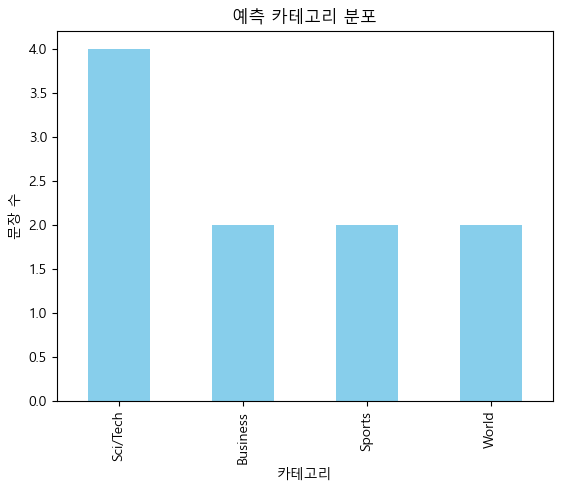

In [95]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정 (Windows: Malgun Gothic)
plt.rc('font', family='Malgun Gothic')

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

df["예측 카테고리"].value_counts().plot(kind="bar", color="skyblue")
plt.title("예측 카테고리 분포")
plt.xlabel("카테고리")
plt.ylabel("문장 수")
plt.show()